In [1]:
from io import open
import glob
import os

In [2]:
def findFiles(path):
    return glob.glob(path)

In [3]:
findFiles('data/nlp-data/names/*.txt')

['data/nlp-data/names/Portuguese.txt',
 'data/nlp-data/names/Czech.txt',
 'data/nlp-data/names/Irish.txt',
 'data/nlp-data/names/Italian.txt',
 'data/nlp-data/names/Korean.txt',
 'data/nlp-data/names/Dutch.txt',
 'data/nlp-data/names/Polish.txt',
 'data/nlp-data/names/Russian.txt',
 'data/nlp-data/names/Japanese.txt',
 'data/nlp-data/names/Chinese.txt',
 'data/nlp-data/names/Spanish.txt',
 'data/nlp-data/names/French.txt',
 'data/nlp-data/names/German.txt',
 'data/nlp-data/names/Vietnamese.txt',
 'data/nlp-data/names/English.txt',
 'data/nlp-data/names/Arabic.txt',
 'data/nlp-data/names/Greek.txt',
 'data/nlp-data/names/Scottish.txt']

In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
n_letters

57

In [6]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [7]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [8]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/nlp-data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [9]:
n_categories

18

In [10]:
category_lines['German'][:10]

['Abbing',
 'Abel',
 'Abeln',
 'Abt',
 'Achilles',
 'Achterberg',
 'Acker',
 'Ackermann',
 'Adam',
 'Adenauer']

### Data Preparation
Make the characters as one-hot encoder vectors, therefore each name would be represented by a set of one-hot vectors

In [11]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [12]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [13]:
letterToIndex('J') # the index of J in the above string

35

In [14]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [15]:
letterToTensor('J') # one-hot vector where the index of J is 1, rest is 0

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [16]:
# Input is a line - the string of the name
# Output : [name_length, 1, num_char_vocab]
# Apparently, that extra 1 dimension is because PyTorch assumes everything is in batches 
# - we’re just using a batch size of 1 here.
# BUT WHY isnt batch size the zeroth dimension 
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, char in enumerate(line):
        tensor[idx][0][letterToIndex(char)] = 1
    
    return tensor

In [17]:
lineToTensor('Jack')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

### Implementation of an RNN Class
From scratch ...

In [18]:
import torch.nn as nn

In [19]:

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        # input dim is the size of the character vocab
        # output dim refers to the number of classes, i.e., 18 here
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Calculate h hiddenstate at each timestep
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        # Calculate o output at each timestep
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        # concatenate current input and previous hidden state 
        combined = torch.cat((input, hidden), 1) 
        
        # compute new hidden state
        hidden = self.i2h(combined)
        
        # compute output at current step
        output = self.i2o(combined)
        
        # output is a softmax layer 
        output = self.softmax(output)
        
        return output, hidden
    
    # Is it ok to initialize with zeros ? Shouldnt we have "near-zero" values?
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [20]:
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [21]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9630, -2.8647, -2.8538, -2.9588, -2.9115, -2.8989, -2.9119, -2.9139,
         -2.7626, -2.7973, -2.9009, -2.9702, -2.8096, -2.8886, -2.9130, -2.9129,
         -2.9399, -2.8830]], grad_fn=<LogSoftmaxBackward>)


But this is the log softmax output at timestep 1 (since we have not so far specified the iteration scheme to go till the end of line)

In [22]:
def categoryFromOutput(output):
    # From the above output, the predicted class is the one with the highest score
    top_n, top_i = output.topk(1) # The value and the index
    
    category_i = top_i[0].item() # predicted class' index
    
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 8)


In [23]:
# Some helper functions to quickly get training examples
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Polish / line = Bobienski
category = Portuguese / line = Ferro
category = Russian / line = Mnuskin
category = Irish / line = Bran
category = Scottish / line = Jackson
category = Polish / line = Wyrzyk
category = Korean / line = Wang
category = Russian / line = Pazhukov
category = Russian / line = Tzelikovsky
category = Russian / line = Lichkus


### Training the Network

In [24]:
# NLL loss
criterion = nn.NLLLoss()

learning_rate = 0.005

In [25]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # for each new input line we start with a zero hidden state initialization
    
    rnn.zero_grad()
    
    # iterate till the end of the line
    for i in range(line_tensor.size()[0]): # line length
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    loss.backward()
    
    # Here, we do not use any optimizer
    # we do the gradient updates manually
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [26]:
import time
import math

n_iters = 60000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    
    # Randomly sample a datapoint in the training set
    # Keep doing for how-many-ever iterations specified
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 8% (1m 14s) 2.7451 Osladil / Irish ✗ (Czech)
10000 16% (2m 17s) 2.6676 Crawford / English ✗ (Scottish)
15000 25% (3m 13s) 1.8863 Kuipers / Dutch ✓
20000 33% (4m 7s) 1.7257 Pinho / Portuguese ✓
25000 41% (5m 1s) 2.4164 Krawiec / Polish ✗ (Czech)
30000 50% (5m 56s) 0.9917 Abbatantuono / Italian ✓
35000 58% (6m 48s) 2.2600 Valencia / Czech ✗ (Spanish)
40000 66% (7m 36s) 1.5559 Cabral / Irish ✗ (Portuguese)
45000 75% (8m 26s) 1.1273 Shamoon / Arabic ✓
50000 83% (9m 9s) 1.9130 Giroux / Arabic ✗ (French)
55000 91% (10m 0s) 0.2938 Yoo / Korean ✓
60000 100% (10m 48s) 1.1502 Tse / Chinese ✓


### Plotting the loss over training

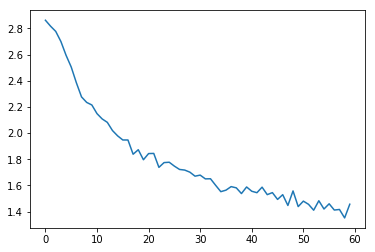

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline 
plt.figure()
plt.plot(all_losses)

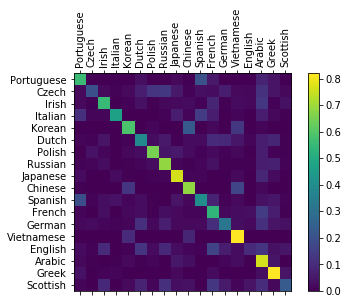

In [28]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Running on User Input

In [30]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.14) Russian
(-2.69) Czech
(-3.31) Greek

> Jackson
(-0.69) Russian
(-1.93) Scottish
(-2.04) English

> Satoshi
(-0.71) Arabic
(-2.18) Japanese
(-2.28) Italian
